In [1]:
#pip install catboost

In [2]:
from kmodes.kprototypes import KPrototypes

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

C:\Users\Vasu\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
os.chdir("D:\great lakes\projects\capstone")

In [5]:
df_screening=pd.read_excel("D:\great lakes\projects\capstone\Medical camp data.xlsx",sheet_name="Screening")
df_follow_up=pd.read_excel("D:\great lakes\projects\capstone\Medical camp data.xlsx",sheet_name="Follow_ups")
df_screening["freq"]=0
for i in np.arange(9998):
    df_screening["freq"].loc[i]=df_follow_up[df_follow_up["Patient_ID"] == df_screening["Patient_ID"][i]].shape[0]

In [6]:
 df_screening.drop(["screen_no","City"],axis=1,inplace=True)  #Since all the patients are from the same city 

In [7]:
missing_values =pd.DataFrame(100*df_screening.isnull().sum()/len(df_screening),columns=["percentage of missing values"]).sort_values(ascending=False,by
                                                                                                       ="percentage of missing values")
missing_values

,percentage of missing values
other_diseases,99.92
Medication_Dyslipidemia,3.90
Mediaction_otherdisease,3.84
Medication_Thyroid,3.73
Medication_DB,3.60
Medication_HTN,3.02
Is_Dyslipidemia,0.42
Is_thyroid,0.42
DB_category,0.24
Disease,0.15


In [8]:
df_screening["Patient_ID"].value_counts()  #Duplicate columns are present

NHIN07111900070001    2
NHIN22021700047001    2
NHIN09121600036006    1
D2D-34094             1
NHIN06031700031004    1
                     ..
D2D-21575             1
D2D-35825             1
NHIN04021700046015    1
D2D-40386             1
D2D-38173             1
Name: Patient_ID, Length: 9998, dtype: int64

In [9]:
df_screening[df_screening["Patient_ID"] == 'NHIN07111900070001']

,Date,Patient_ID,Age,Gender,Medication_DB,Medication_HTN,Medication_Thyroid,Medication_Dyslipidemia,other_diseases,Mediaction_otherdisease,...,Is_diabetic,DB_family,DB_category,OB_category,Heart_attack,Smoking,Alcohol,BMI,Disease,freq
4496,2019-11-07,NHIN07111900070001,67,F,0.0,1.0,0.0,NaN,Breast Cancer,1.0,...,Y,N,1.0,2.0,N,N,0,26.2,Diabetes-Hypertension-Obesity-ThyroidDisorder,0
4497,2019-11-07,NHIN07111900070001,67,F,0.0,1.0,0.0,NaN,Breast Cancer,1.0,...,Y,N,NaN,NaN,N,N,0,NaN,-,0


In [10]:
df_screening.drop(4497,axis=0,inplace=True)    

In [11]:
df_screening[df_screening["Patient_ID"] == 'NHIN22021700047001'] 

,Date,Patient_ID,Age,Gender,Medication_DB,Medication_HTN,Medication_Thyroid,Medication_Dyslipidemia,other_diseases,Mediaction_otherdisease,...,Is_diabetic,DB_family,DB_category,OB_category,Heart_attack,Smoking,Alcohol,BMI,Disease,freq
8802,2016-08-29,NHIN22021700047001,38,M,0.0,0.0,0.0,0.0,NaN,0.0,...,N,N,0.0,0.0,N,N,0,20.88,Healthy,2
8803,2017-02-22,NHIN22021700047001,38,M,0.0,0.0,0.0,0.0,NaN,0.0,...,N,N,0.0,0.0,N,N,0,21.13,Healthy,2


In [12]:
df_screening.drop(8803,axis=0,inplace=True)    #considering 2016 details of the patient

In [13]:
patient_id=df_screening["Patient_ID"]

In [14]:
df_screening.drop(["Patient_ID"],axis=1,inplace=True)  #Other disease more than 99% of the column is empty
#"other_diseases"

In [15]:
categorical_variables=df_screening.select_dtypes(include='object').columns
print(categorical_variables)

Index(['Gender', 'other_diseases', 'is_hypertension', 'Hypertension_family',
       'Is_diabetic', 'DB_family', 'Heart_attack', 'Smoking', 'Disease'],
      dtype='object')


In [16]:
df_screening["Gender"].replace({"M":0,"F":1},inplace=True)
df_screening["Smoking"].replace({"N":0,"Y":1},inplace=True)
df_screening["Heart_attack"].replace({"N":0,"Y":1},inplace=True)
df_screening["DB_family"].replace({"N":0,"Y":1},inplace=True)
df_screening["Is_diabetic"].replace({"N":0,"Y":1},inplace=True)
df_screening["Hypertension_family"].replace({"N":0,"Y":1},inplace=True)
df_screening["is_hypertension"].replace({"N":0,"Y":1},inplace=True)

In [17]:
df_screening['Disease'] = df_screening['Disease'].replace('-', '')
df_screening["Disease"] = df_screening["Disease"].replace('Healthy',0)

idx=df_screening[(df_screening["Disease"] != 0) & (df_screening["Disease"].notnull())].index
df_screening["Disease"].loc[idx] = 1
df_screening["Disease"]=pd.to_numeric(df_screening["Disease"],errors='coerce')

In [18]:
df_screening["Disease"].value_counts()

1.0    5312
0.0    4671
Name: Disease, dtype: int64

In [19]:
df_date=df_screening["Date"]
df_screening.drop("Date",axis=1,inplace=True)

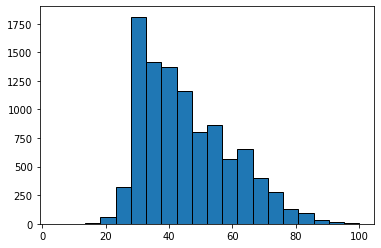

In [20]:
plt.hist(df_screening["Age"],bins=20,edgecolor='black');

## Imputations

In [21]:
df_screening.drop(["Mediaction_otherdisease","other_diseases"],axis=1,inplace=True)

In [22]:
idx=df_screening[df_screening["Disease"].isnull()].index
for i in idx:
    if (df_screening["Is_diabetic"].loc[i] == 1) | (df_screening["Is_thyroid"].loc[i] == 1) | (df_screening["Is_Dyslipidemia"].loc[i] == 1) | (df_screening["is_hypertension"].loc[i] == 1):
        df_screening["Disease"].loc[i] = 1

In [23]:
idx=df_screening[(df_screening["BP_riskscore"] > 1) & (df_screening["Age"] >= 45) & df_screening["Is_Dyslipidemia"].isnull()].index
df_screening["Is_Dyslipidemia"].loc[idx]=1
df_screening["Is_Dyslipidemia"].fillna(0,inplace=True)

In [24]:
idx=df_screening[(df_screening["BMI"] > 25) | (df_screening["OB_category"] > 1) | (df_screening["BP_riskscore"] > 1) & (df_screening["DB_category"].isnull() == True)].index
df_screening["DB_category"].loc[idx]=2
df_screening["DB_category"].fillna(0,inplace=True)

In [25]:
idx=df_screening[(df_screening["BMI"] > 25) & (df_screening["Is_thyroid"].isnull() == True)].index
df_screening["Is_thyroid"].loc[idx]=1
df_screening["Is_thyroid"].fillna(0,inplace=True)

In [26]:
def replace_null_values(df,med_col,dis_col):
    idx=df[df[med_col].isnull()].index
    for i in idx:
        if (df[dis_col].loc[i] == 1):
            df[med_col].loc[i]=1
        elif (df[dis_col].loc[i] == 0):
            df[med_col].loc[i]=0
    return df

In [27]:
replace_null_values(df_screening,"Medication_DB","Is_diabetic")
replace_null_values(df_screening,"Medication_HTN","is_hypertension")
replace_null_values(df_screening,"Medication_Thyroid","Is_thyroid")
replace_null_values(df_screening,"Medication_Dyslipidemia","Is_Dyslipidemia")

,Age,Gender,Medication_DB,Medication_HTN,Medication_Thyroid,Medication_Dyslipidemia,Is_thyroid,Is_Dyslipidemia,is_hypertension,Hypertension_family,...,Is_diabetic,DB_family,DB_category,OB_category,Heart_attack,Smoking,Alcohol,BMI,Disease,freq
0,39,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0.0,0.0,0,0,0,19.25,0.0,0
1,34,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0.0,0.0,0,0,0,18.86,0.0,0
2,74,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0.0,0.0,0,0,0,18.83,1.0,0
3,39,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1.0,0.0,0,0,0,19.91,0.0,0
4,34,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0.0,0.0,0,0,0,21.57,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,2.0,2.0,0,0,0,26.78,1.0,0
9996,59,0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,...,0,0,1.0,1.0,0,0,0,24.58,1.0,0
9997,69,0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,...,1,1,2.0,2.0,0,0,0,27.49,1.0,0
9998,50,0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,...,0,1,2.0,2.0,0,0,0,26.44,1.0,0


In [28]:
df_screening.isnull().sum()

Age                        0
Gender                     0
Medication_DB              0
Medication_HTN             0
Medication_Thyroid         0
Medication_Dyslipidemia    0
Is_thyroid                 0
Is_Dyslipidemia            0
is_hypertension            0
Hypertension_family        0
BP_riskscore               0
Is_diabetic                0
DB_family                  0
DB_category                0
OB_category                0
Heart_attack               0
Smoking                    0
Alcohol                    0
BMI                        0
Disease                    0
freq                       0
dtype: int64

In [29]:
cols=df_screening.columns

In [30]:
df_freq=df_screening["freq"]
df_screening.drop("freq",axis=1,inplace=True)

In [31]:
cols=df_screening.columns

In [32]:
df=df_screening.copy()

### K - modes

In [33]:
import plusmodules as pm

In [34]:
from kmodes.kmodes import KModes
km = KModes(n_clusters = 3)

In [35]:
c = km.fit_predict(df_screening[cols])

In [36]:
print(km.cluster_centroids_)

[[44.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    2.    2.    0.    0.    0.   25.83  1.  ]
 [54.    1.    1.    1.    0.    0.    0.    0.    1.    0.    2.    1.
   0.    2.    2.    0.    0.    0.   26.69  1.  ]
 [29.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.   21.53  0.  ]]


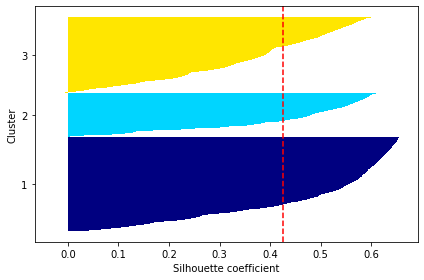

In [37]:
pm.svisualizer(df_screening, 3)

In [38]:
df['labels_kmodes'] = km.labels_

## Agglomerative

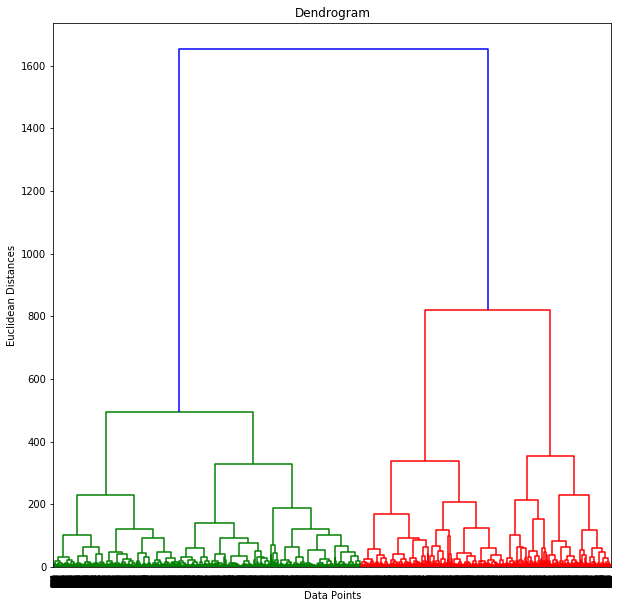

In [39]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.figure(figsize=[10,10])
merg = linkage(df_screening, method='ward')
dendrogram(merg, leaf_rotation=90)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distances')
plt.show()

In [40]:
from sklearn.cluster import AgglomerativeClustering

hie_clus = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df["labels_hie"] = hie_clus.fit_predict(df_screening)

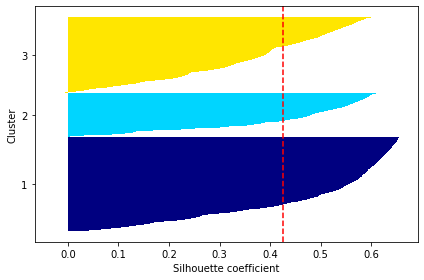

In [41]:
pm.svisualizer(df_screening, 3)

In [42]:
df[df["labels_hie"] == df["labels_kmodes"]]["Age"].count()

3748

In [43]:
df["labels_hie"].value_counts()

0    5516
2    2583
1    1899
Name: labels_hie, dtype: int64

In [44]:
df["labels_kmodes"].value_counts()

0    4697
2    3957
1    1344
Name: labels_kmodes, dtype: int64

In [45]:
df.groupby("labels_hie").count()

,Age,Gender,Medication_DB,Medication_HTN,Medication_Thyroid,Medication_Dyslipidemia,Is_thyroid,Is_Dyslipidemia,is_hypertension,Hypertension_family,...,Is_diabetic,DB_family,DB_category,OB_category,Heart_attack,Smoking,Alcohol,BMI,Disease,labels_kmodes
labels_hie,,,,,,,,,,,,,,,,,,,,,
0,5516,5516,5516,5516,5516,5516,5516,5516,5516,5516,...,5516,5516,5516,5516,5516,5516,5516,5516,5516,5516
1,1899,1899,1899,1899,1899,1899,1899,1899,1899,1899,...,1899,1899,1899,1899,1899,1899,1899,1899,1899,1899
2,2583,2583,2583,2583,2583,2583,2583,2583,2583,2583,...,2583,2583,2583,2583,2583,2583,2583,2583,2583,2583


In [46]:
from sklearn.metrics import silhouette_score

In [47]:
X=df_screening
y1=df["labels_hie"]
y2=df["labels_kmodes"]
print(silhouette_score(X,y1))
print(silhouette_score(X,y2))

0.403775143625357
0.038134475303882996


In [48]:
pd.set_option("display.max_rows",None)
df.groupby("labels_hie").describe().T

labels_hie                               0            1            2
Age                     count  5516.000000  1899.000000  2583.000000
                        mean     34.787890    68.302791    50.775842
                        std       5.577702     7.569450     4.473747
                        min       4.000000    56.000000    32.000000
                        25%      30.000000    63.000000    48.000000
                        50%      34.000000    67.000000    50.000000
                        75%      39.000000    73.000000    54.000000
                        max      47.000000   100.000000    73.000000
Gender                  count  5516.000000  1899.000000  2583.000000
                        mean      0.528644     0.431280     0.489353
                        std       0.499224     0.495385     0.499983
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       1.000000     0.000000     0.000000
                        75%       1.000000     1.000000     1.000000
                        max       1.000000     1.000000     1.000000
Medication_DB           count  5516.000000  1899.000000  2583.000000
                        mean      0.040790     0.331227     0.202091
                        std       0.197822     0.470778     0.401637
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     1.000000     0.000000
                        max       1.000000     1.000000     1.000000
Medication_HTN          count  5516.000000  1899.000000  2583.000000
                        mean      0.047317     0.500790     0.287650
                        std       0.212335     0.500131     0.452755
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     1.000000     0.000000
                        75%       0.000000     1.000000     1.000000
                        max       1.000000     1.000000     1.000000
Medication_Thyroid      count  5516.000000  1899.000000  2583.000000
                        mean      0.004714     0.000527     0.002323
                        std       0.068500     0.022948     0.048150
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       1.000000     1.000000     1.000000
Medication_Dyslipidemia count  5516.000000  1899.000000  2583.000000
                        mean      0.000000     0.000527     0.000774
                        std       0.000000     0.022948     0.027821
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       0.000000     1.000000     1.000000
Is_thyroid              count  5516.000000  1899.000000  2583.000000
                        mean      0.004895     0.001053     0.002323
                        std       0.069798     0.032444     0.048150
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       1.000000     1.000000     1.000000
Is_Dyslipidemia         count  5516.000000  1899.000000  2583.00000

## Conclusion :
- Cluster 0 (Low risk)
- Cluster 2 (Medium risk)
- Cluster 1 (High risk)

### k-prototypes

In [49]:
kp = KPrototypes(n_clusters = 3,max_iter =20, random_state = 0)

In [50]:
ak = df.values

In [51]:
clusters = kp.fit_predict(ak,categorical = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20])

In [54]:
silhouette_score(df_screening,clusters) 

0.4200824221154356

In [58]:
df["kproto"]=clusters

In [59]:
df.to_excel('disease_pred_new.xlsx',sheet_name="Screening",index=False)

In [60]:
df.groupby("kproto").describe().T

kproto                                   0            1            2
Age                     count  3695.000000  2064.000000  4239.000000
                        mean     47.374019    67.587694    32.602736
                        std       5.184080     7.666463     4.309329
                        min      32.000000    57.000000     4.000000
                        25%      43.000000    62.000000    29.000000
                        50%      47.000000    66.000000    32.000000
                        75%      52.000000    72.000000    36.000000
                        max      59.000000   100.000000    44.000000
Gender                  count  3695.000000  2064.000000  4239.000000
                        mean      0.486874     0.433624     0.543760
                        std       0.499895     0.495695     0.498140
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     1.000000
                        75%       1.000000     1.000000     1.000000
                        max       1.000000     1.000000     1.000000
Medication_DB           count  3695.000000  2064.000000  4239.000000
                        mean      0.173478     0.318798     0.018165
                        std       0.378711     0.466124     0.133562
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     1.000000     0.000000
                        max       1.000000     1.000000     1.000000
Medication_HTN          count  3695.000000  2064.000000  4239.000000
                        mean      0.231664     0.486919     0.022175
                        std       0.421953     0.499950     0.147270
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     1.000000     0.000000
                        max       1.000000     1.000000     1.000000
Medication_Thyroid      count  3695.000000  2064.000000  4239.000000
                        mean      0.002165     0.000484     0.005662
                        std       0.046486     0.022011     0.075040
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       1.000000     1.000000     1.000000
Medication_Dyslipidemia count  3695.000000  2064.000000  4239.000000
                        mean      0.000271     0.000969     0.000000
                        std       0.016451     0.031121     0.000000
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       1.000000     1.000000     0.000000
Is_thyroid              count  3695.000000  2064.000000  4239.000000
                        mean      0.002165     0.000969     0.005898
                        std       0.046486     0.031121     0.076578
                        min       0.000000     0.000000     0.000000
                        25%       0.000000     0.000000     0.000000
                        50%       0.000000     0.000000     0.000000
                        75%       0.000000     0.000000     0.000000
                        max       1.000000     1.000000     1.000000
Is_Dyslipidemia         count  3695.000000  2064.000000  4239.00000

In [61]:
df_screening["kproto"]=clusters

## Statistical test

In [62]:
import scipy.stats as st

In [63]:
col1=['Gender', 'Medication_DB', 'Medication_HTN',
       'Medication_Thyroid', 'Medication_Dyslipidemia', 'Is_thyroid',
       'Is_Dyslipidemia', 'is_hypertension', 'Hypertension_family',
       'BP_riskscore', 'Is_diabetic', 'DB_family', 'DB_category',
       'OB_category', 'Heart_attack', 'Smoking', 'Alcohol', 'Disease']

In [66]:
def test_of_association(independent,dependent,df):
    table=pd.crosstab(df[independent],df[dependent])
    chisq,pval,dof,exp=st.chi2_contingency(table)
    return chisq,pval 

In [68]:
Z_critical=st.chi2.isf(0.05,1)
print(f"Column                               pval   Z_observed    Z_critical")
for i in col1:
    chisq,pval=test_of_association(i,"kproto",df_screening)
    print("-"*70)
    print(f"{i:30}{round(pval,2):10}{round(chisq,2):10}{round(Z_critical,2):10}")

Column                               pval   Z_observed    Z_critical
----------------------------------------------------------------------
Gender                               0.0     71.39      3.84
----------------------------------------------------------------------
Medication_DB                        0.0   1120.53      3.84
----------------------------------------------------------------------
Medication_HTN                       0.0   1954.59      3.84
----------------------------------------------------------------------
Medication_Thyroid                   0.0     13.61      3.84
----------------------------------------------------------------------
Medication_Dyslipidemia             0.11      4.36      3.84
----------------------------------------------------------------------
Is_thyroid                           0.0     12.66      3.84
----------------------------------------------------------------------
Is_Dyslipidemia                     0.35      2.11      3.84
-------

## Feature Selection:

In [69]:
df_screening.columns

Index(['Age', 'Gender', 'Medication_DB', 'Medication_HTN',
       'Medication_Thyroid', 'Medication_Dyslipidemia', 'Is_thyroid',
       'Is_Dyslipidemia', 'is_hypertension', 'Hypertension_family',
       'BP_riskscore', 'Is_diabetic', 'DB_family', 'DB_category',
       'OB_category', 'Heart_attack', 'Smoking', 'Alcohol', 'BMI', 'Disease',
       'kproto'],
      dtype='object')

In [70]:
df=df_screening.drop(['Is_thyroid','Is_Dyslipidemia', 'is_hypertension','Is_diabetic','Disease','Alcohol','Medication_Dyslipidemia'],axis=1)

In [71]:
df.shape

(9998, 14)

In [72]:
df.columns

Index(['Age', 'Gender', 'Medication_DB', 'Medication_HTN',
       'Medication_Thyroid', 'Hypertension_family', 'BP_riskscore',
       'DB_family', 'DB_category', 'OB_category', 'Heart_attack', 'Smoking',
       'BMI', 'kproto'],
      dtype='object')

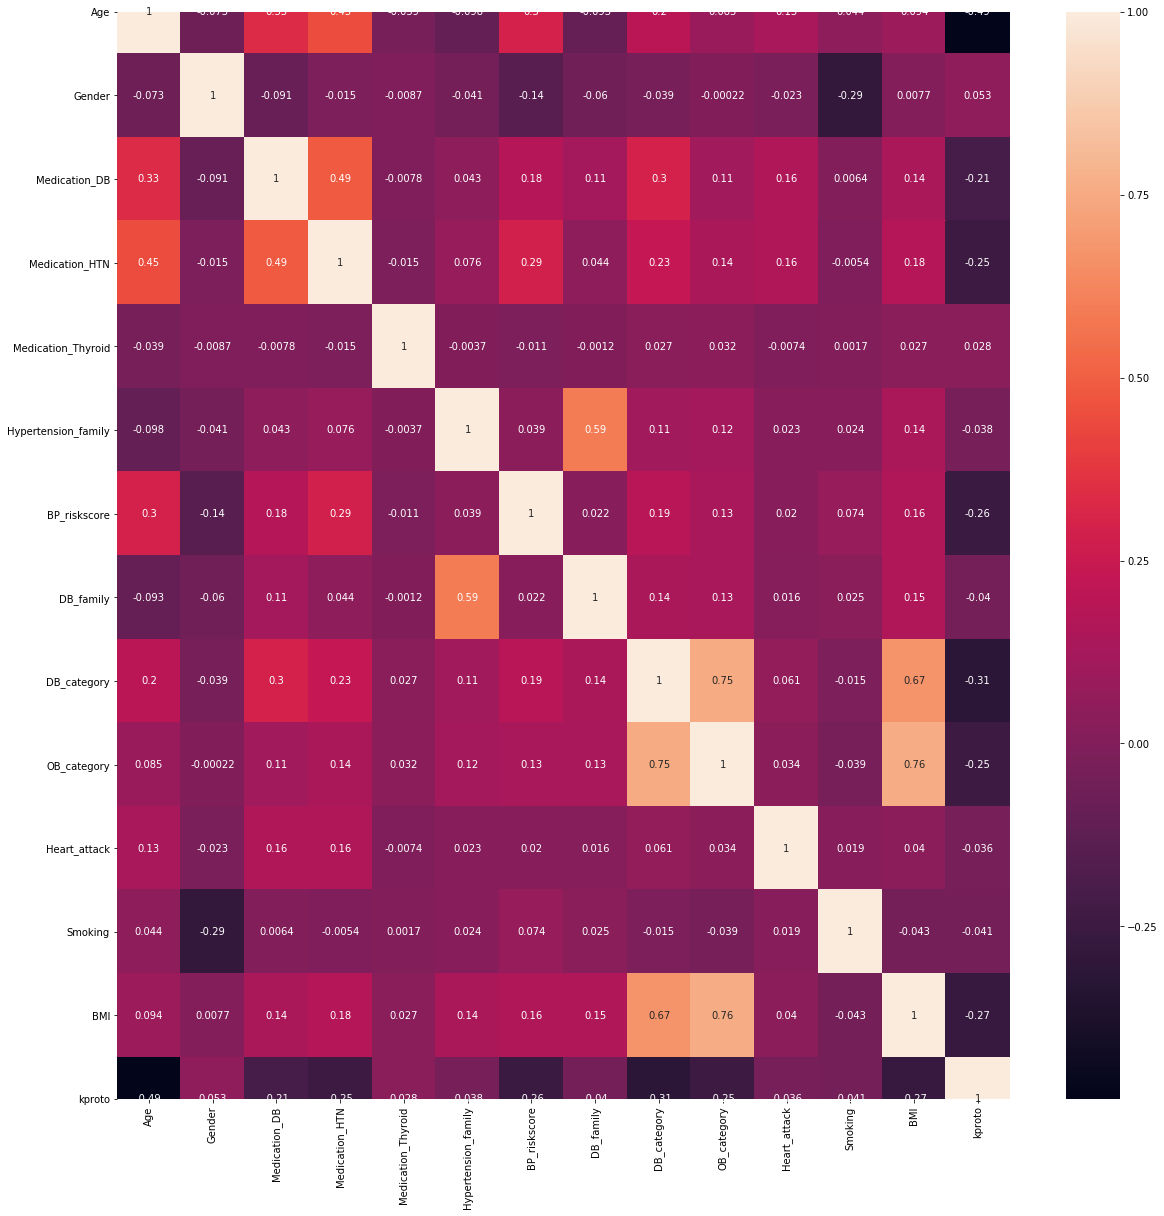

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

In [74]:
X=df.drop("kproto",axis=1)
y=df.kproto

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

[variance_inflation_factor(X.values, j) for j in range(1, X.shape[1])]

[2.1784072557503213,
 1.7155712015336264,
 1.8888418204956443,
 1.0062422673414482,
 2.0475257131903484,
 1.6906541640423955,
 2.0190686397935207,
 5.804092721228003,
 8.009630159562741,
 1.059242468322972,
 1.1858074049189242,
 19.140458596665187]

In [84]:
from sklearn.linear_model import LassoCV

Best alpha using built-in LassoCV: 0.006149
Best score using built-in LassoCV: 0.304996
Lasso picked 8 variables and eliminated the other 5 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

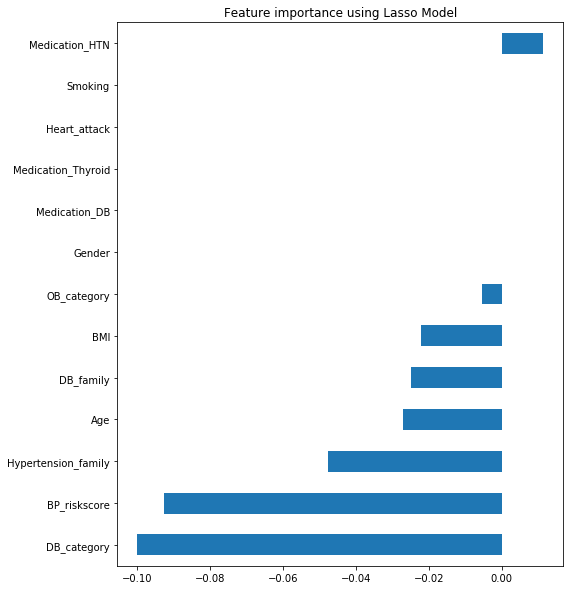

In [85]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")


In [ ]:
X1=df_screening.drop("labels_hie",axis=1)

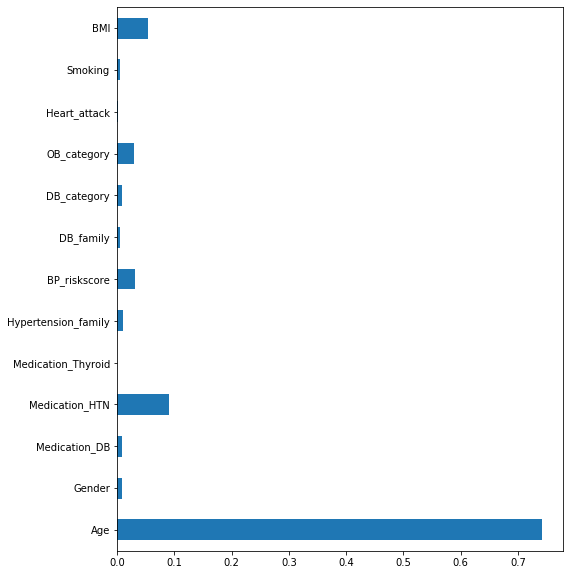

In [86]:
from sklearn.tree import ExtraTreeClassifier

#dt=DecisionTreeClassifier()
etc=ExtraTreeClassifier()
etc.fit(X,y)

result=etc.feature_importances_

result=pd.Series(result,index=X.columns)
result.plot(kind='barh')
plt.show()

## Model building:

In [88]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from catboost import CatBoostClassifier

In [129]:
nb=GaussianNB()
knn=KNeighborsClassifier(n_neighbors=10)
dt=DecisionTreeClassifier(max_depth=5,random_state=0)
rf=RandomForestClassifier(random_state=0)
bagging=BaggingClassifier(random_state=0)
adaboost=AdaBoostClassifier(random_state=0)
gradboost=GradientBoostingClassifier(random_state=0)
catboost=CatBoostClassifier(learning_rate=0.5,random_state=0,custom_metric=["F1"],verbose=False)

In [130]:
models=[]
models.append(("Naive Bayes",nb))
models.append(("KNN",knn))
models.append(("Decision Tree",dt))
models.append(("Random Forest",rf))
models.append(("Bagging",bagging))
models.append(("Ada Boost",adaboost))
models.append(("Gradient Boost",gradboost))
models.append(("Cat Boost",catboost))

In [131]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,accuracy_score,confusion_matrix,f1_score

In [136]:
from sklearn.preprocessing import StandardScaler
Xs=StandardScaler().fit_transform(X)
Xs=pd.DataFrame(Xs,columns=X.columns)

In [133]:
# evaluate each model in turn
results = []
names = []
print(f'classifier\t\tBias Error\tVariance Error')
print('-'*55)
for name, model in models:
    kfold = KFold(shuffle=True,n_splits=3,random_state=0)
    cv_results =cross_val_score(model, Xs, y,cv=kfold, scoring='f1_weighted')
    results.append(cv_results)
    names.append(name)
    print(f'{name:23}: {round(np.mean(cv_results),3):5}  {round(np.var(cv_results,ddof=1),7):19}')
    print('-'*55)

classifier		Bias Error	Variance Error
-------------------------------------------------------
Naive Bayes            : 0.764            0.0378274
-------------------------------------------------------
KNN                    : 0.889             1.61e-05
-------------------------------------------------------
Decision Tree          : 0.978              8.3e-06
-------------------------------------------------------
Random Forest          : 0.991             1.05e-05
-------------------------------------------------------
Bagging                : 0.991              5.7e-06
-------------------------------------------------------
Ada Boost              : 0.585             0.050939
-------------------------------------------------------
Gradient Boost         : 0.992              9.1e-06
-------------------------------------------------------
Cat Boost              : 0.993              6.7e-06
-------------------------------------------------------


In [137]:
from sklearn.model_selection import StratifiedShuffleSplit

print('cluster : 0', round(y.value_counts()[0]/len(y) * 100,2), '% of the dataset')
print('cluster : 1', round(y.value_counts()[1]/len(y) * 100,2), '% of the dataset')
print('cluster : 2', round(y.value_counts()[2]/len(y) * 100,2), '% of the dataset')
print('-'*50)

sss = StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.3)

for train_index, test_index in sss.split(Xs, y):
    X_train, X_test = Xs.iloc[train_index], Xs.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
print('cluster : 0', round(y_train.value_counts()[0]/len(y_train) * 100,2), '% of the dataset')
print('cluster : 1', round(y_train.value_counts()[1]/len(y_train) * 100,2), '% of the dataset')
print('cluster : 2', round(y_train.value_counts()[2]/len(y_train) * 100,2), '% of the dataset')
print('-'*50)

print('cluster : 0', round(y_test.value_counts()[0]/len(y_test) * 100,2), '% of the dataset')
print('cluster : 1', round(y_test.value_counts()[1]/len(y_test) * 100,2), '% of the dataset')
print('cluster : 2', round(y_test.value_counts()[2]/len(y_test) * 100,2), '% of the dataset')
print('-'*50)

cluster : 0 36.96 % of the dataset
cluster : 1 20.64 % of the dataset
cluster : 2 42.4 % of the dataset
--------------------------------------------------
cluster : 0 36.95 % of the dataset
cluster : 1 20.65 % of the dataset
cluster : 2 42.4 % of the dataset
--------------------------------------------------
cluster : 0 36.97 % of the dataset
cluster : 1 20.63 % of the dataset
cluster : 2 42.4 % of the dataset
--------------------------------------------------


In [143]:
from scipy.stats import ttest_ind

In [144]:
ttest_ind(Xs,X_train)

Ttest_indResult(statistic=array([ 0.07757261, -0.66010442, -0.15637965,  0.26345776,  0.17724624,
        0.83320957,  0.28106504,  0.71795725, -0.75578658, -0.80835299,
       -0.23963858,  0.41918987, -0.49053167]), pvalue=array([0.93816895, 0.50919577, 0.87573563, 0.79220097, 0.85931709,
       0.40473826, 0.77866393, 0.47279352, 0.44978764, 0.41889872,
       0.81061334, 0.67508267, 0.62376406]))

In [141]:
catboost=CatBoostClassifier(learning_rate=0.5,random_state=0,custom_metric=["F1"],verbose=False)
catboost.fit(X_train,y_train)
predict_catboost=catboost.predict(X_test)
catboost.score(X_test,y_test)

0.9943333333333333

In [142]:
print(classification_report(y_test,predict_catboost))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1109
           1       0.99      1.00      1.00       619
           2       1.00      1.00      1.00      1272

    accuracy                           0.99      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       0.99      0.99      0.99      3000

